In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [2]:
# 한글 폰트 깨지지 않게 하기
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

### 데이터 전처리 및 결측치 제거

In [3]:
raw_data = pd.read_csv("../../01.files/02.Bigsata_analysis/통신고객이탈.csv", encoding = 'euc-kr')
raw_data.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHURN               930 non-null    object 
 1   CUSTOMER_ID         930 non-null    object 
 2   GENDER              930 non-null    object 
 3   AGE                 930 non-null    int64  
 4   CHARGE_TYPE         930 non-null    object 
 5   HANDSET             930 non-null    object 
 6   USAGE_BAND          930 non-null    object 
 7   SERVICE_DURATION    930 non-null    float64
 8   DROPPED_CALLS       930 non-null    int64  
 9   PEAK_CALLS_NO       930 non-null    int64  
 10  PEAK_CALLS_TIME     930 non-null    float64
 11  WEEKEND_CALLS_NO    930 non-null    int64  
 12  WEEKEND_CALLS_TIME  930 non-null    float64
 13  TOTAL_CALLS_NO      930 non-null    int64  
 14  TOTAL_CALLS_TIME    930 non-null    float64
dtypes: float64(4), int64(5), object(6)
memory usage: 109.1+ K

In [5]:
raw_data.isnull().sum()

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

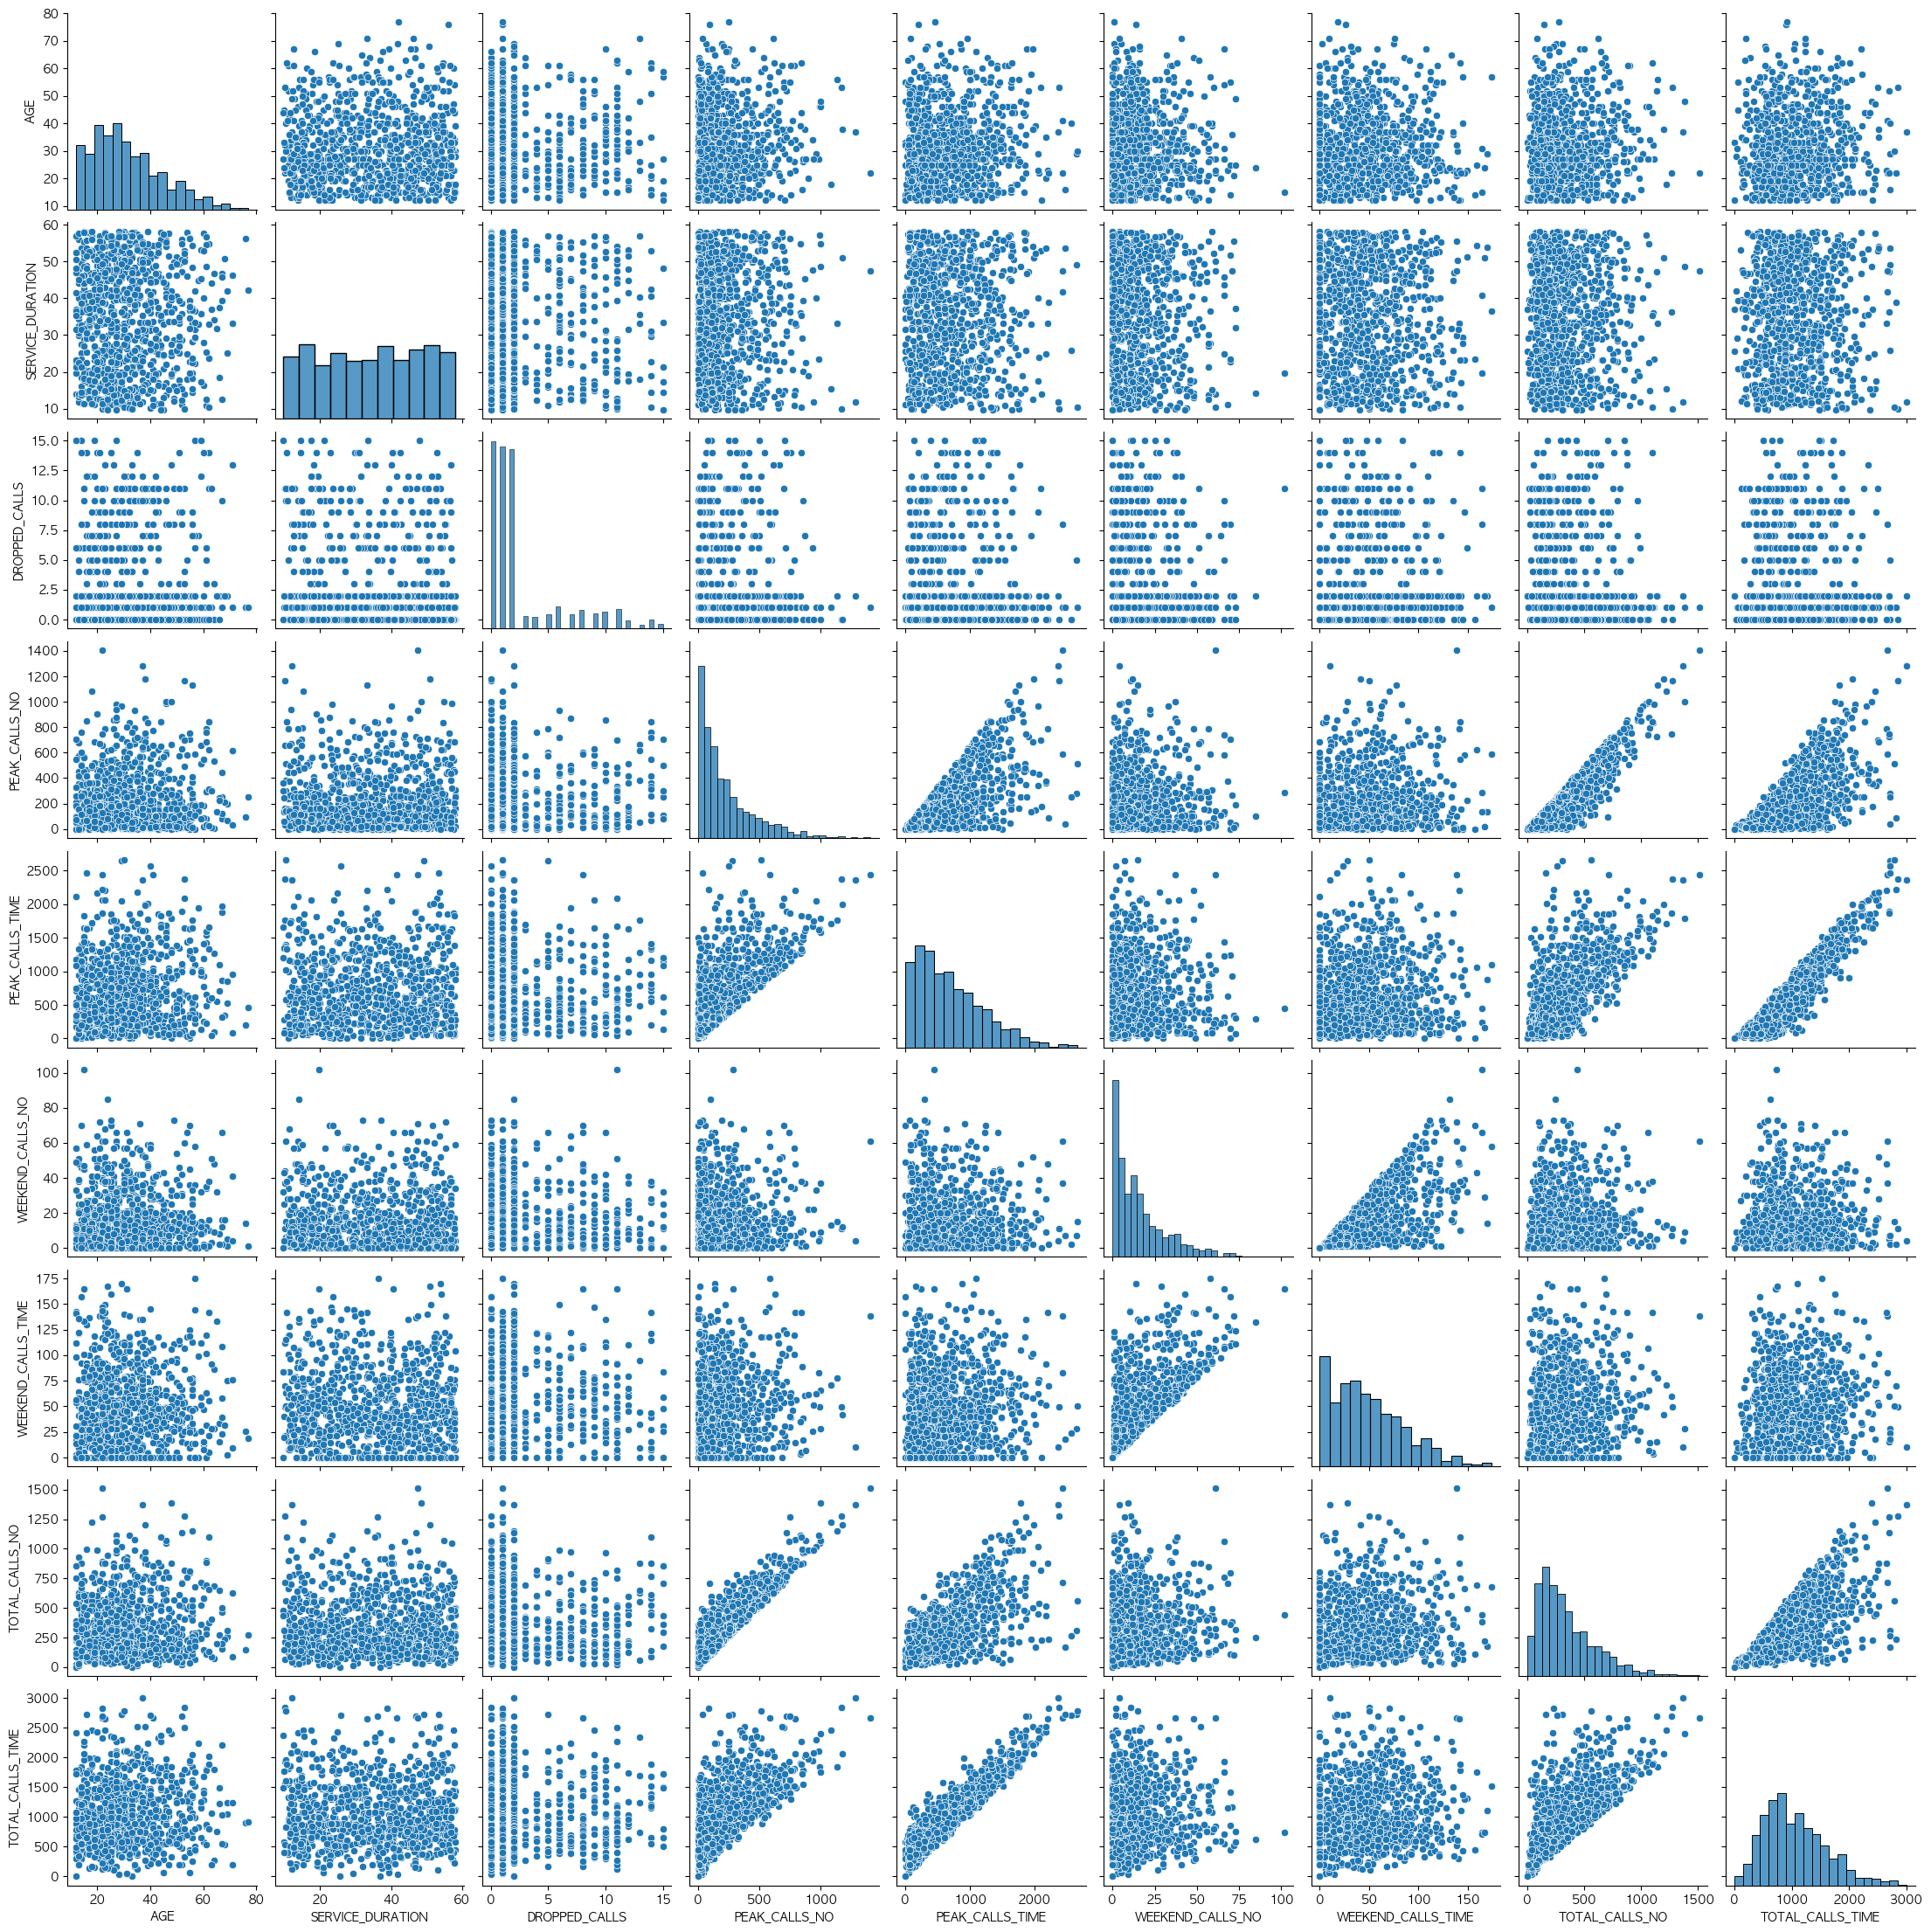

In [6]:
sns.pairplot(raw_data)

In [7]:
raw_data.corr()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
AGE,1.000000,0.026100,0.021547,0.089831,0.097833,0.020206,-0.005394,0.067839,0.084975
SERVICE_DURATION,0.026100,1.000000,-0.083783,0.016312,0.019596,-0.026734,-0.039490,-0.003251,0.006042
DROPPED_CALLS,0.021547,-0.083783,1.000000,0.014470,-0.015857,0.009163,0.026940,0.011692,-0.020352
PEAK_CALLS_NO,0.089831,0.016312,0.014470,1.000000,0.692672,0.019736,0.073414,0.918290,0.656455
PEAK_CALLS_TIME,0.097833,0.019596,-0.015857,0.692672,1.000000,-0.012848,0.051780,0.624578,0.930593
WEEKEND_CALLS_NO,0.020206,-0.026734,0.009163,0.019736,-0.012848,1.000000,0.706630,0.075019,0.030228
WEEKEND_CALLS_TIME,-0.005394,-0.039490,0.026940,0.073414,0.051780,0.706630,1.000000,0.102849,0.106207
TOTAL_CALLS_NO,0.067839,-0.003251,0.011692,0.918290,0.624578,0.075019,0.102849,1.000000,0.690575
TOTAL_CALLS_TIME,0.084975,0.006042,-0.020352,0.656455,0.930593,0.030228,0.106207,0.690575,1.000000


### 필요없는 x 드랍, 및 상관계수가 높은 x 제거, 목표변수 0과 1로 값 변경
- 위에서 본 다중공선성 결과를 보았을때 PEAK_CALLS_NO, WEEKEND_CALLS_NO, TOTAL_CALLS_NO 간     
PEAK_CALLS_TIME, WEEKEND_CALLS_TIME, TOTAL_CALLS_TIME 간,     
각 항목의 NO와 TIME 간의 상관관계가 높은것을 확인할 수 있다. 
- 이에 따라 각 항목이 겹치면서 모델의 학습을 방해하는 것을 방지하기 위하여 NO와 PEAK는 TOTAL 값만 남겨두기로 결정하였다.
- 이외에 CUSTOMER_ID는 각 고객의 고유한 번호이므로 데이터에서 제거하기로 결정하였다. 

In [8]:
raw_data.drop(['CUSTOMER_ID', 'PEAK_CALLS_NO','PEAK_CALLS_TIME', 'WEEKEND_CALLS_NO','WEEKEND_CALLS_TIME'], axis = 1, inplace = True)
raw_data['CHURN'] = pd.get_dummies(raw_data['CHURN'], drop_first=True)
raw_data.head()

,CHURN,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,0,F,31,CAT 100,ASAD170,Med,33.33,6,366,632.4
1,0,M,27,CAT 100,S50,Med,30.87,10,411,810.4
2,0,M,27,CAT 100,ASAD170,Med,49.40,11,265,614.1
3,0,M,61,CAT 100,ASAD170,Med,48.60,1,326,844.0
4,0,F,52,CAT 100,S50,Med,56.03,0,274,673.0


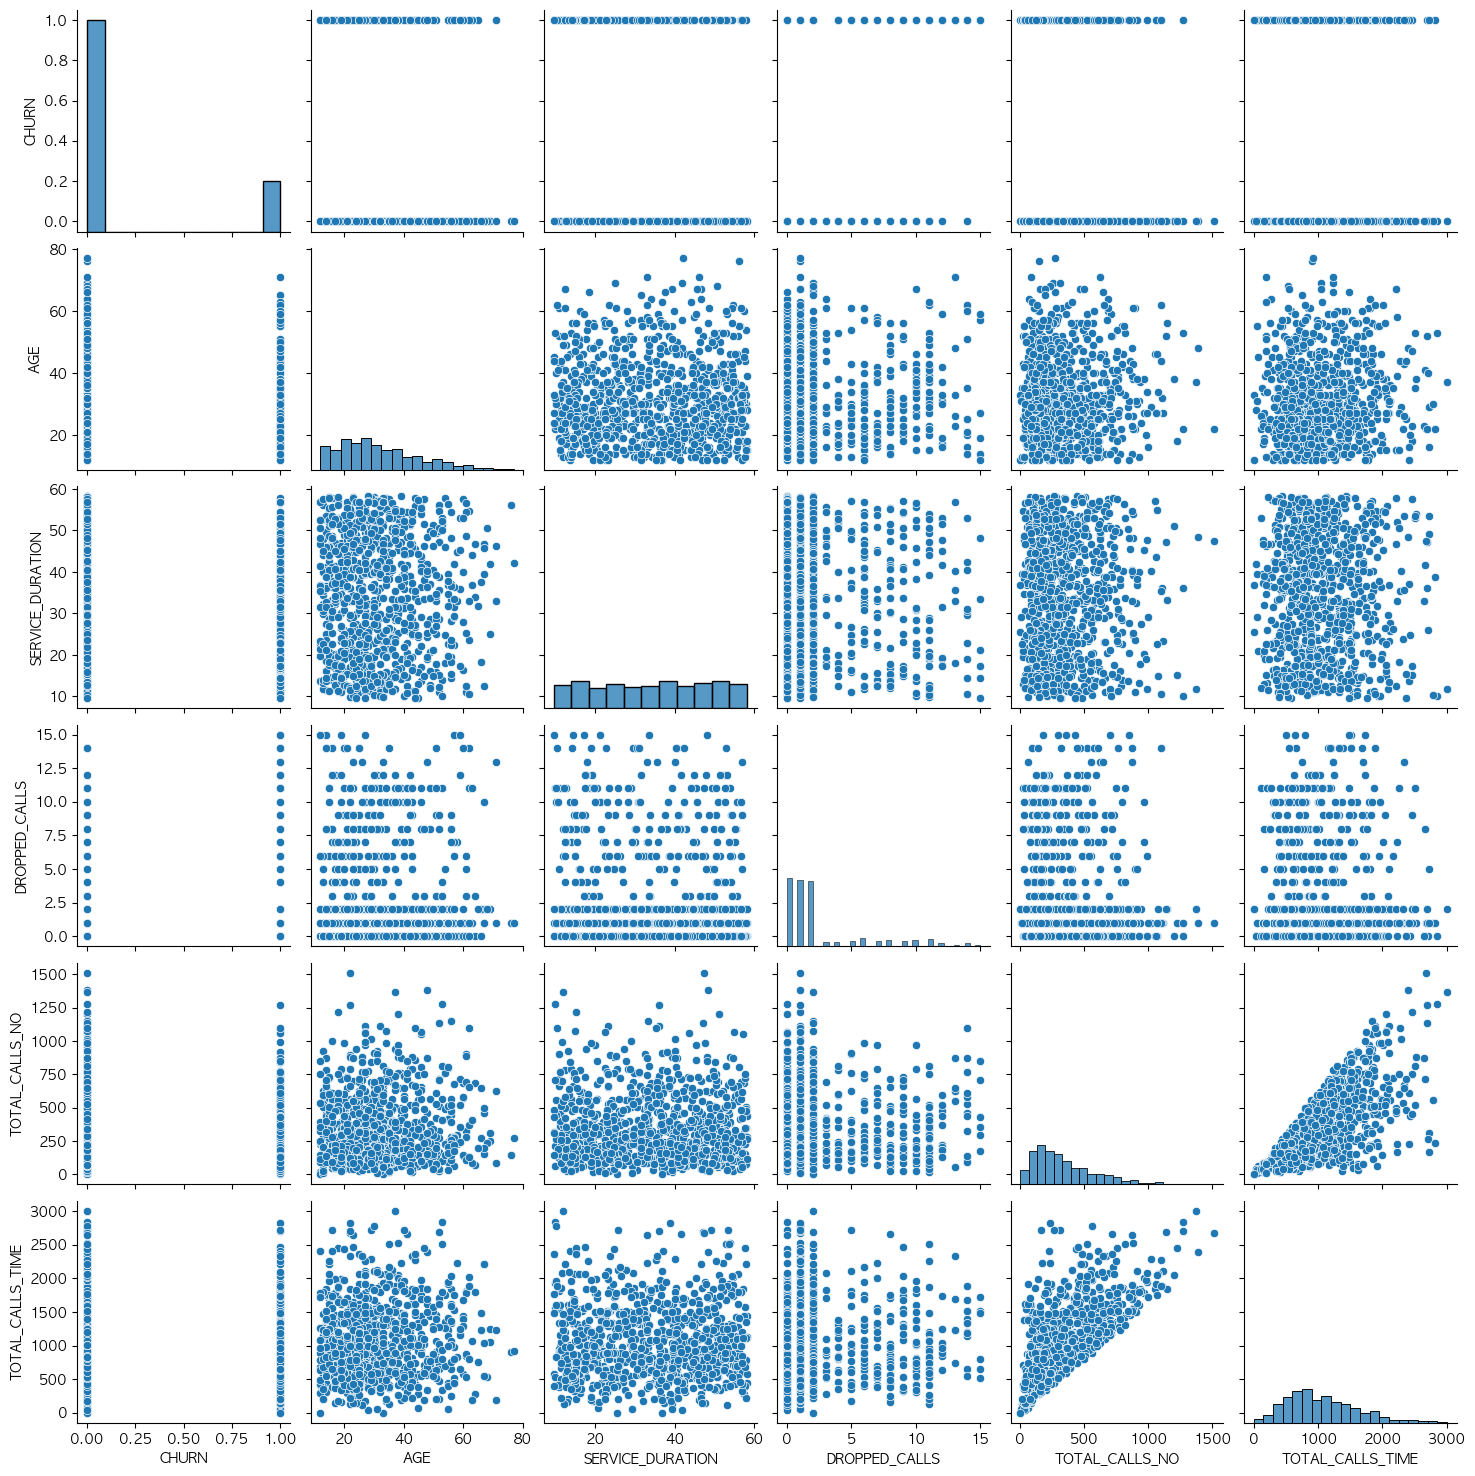

In [9]:
sns.pairplot(raw_data)

In [10]:
raw_data.corr()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
CHURN,1.000000,-0.088926,-0.083079,0.197524,-0.021957,-0.027112
AGE,-0.088926,1.000000,0.026100,0.021547,0.067839,0.084975
SERVICE_DURATION,-0.083079,0.026100,1.000000,-0.083783,-0.003251,0.006042
DROPPED_CALLS,0.197524,0.021547,-0.083783,1.000000,0.011692,-0.020352
TOTAL_CALLS_NO,-0.021957,0.067839,-0.003251,0.011692,1.000000,0.690575
TOTAL_CALLS_TIME,-0.027112,0.084975,0.006042,-0.020352,0.690575,1.000000


#### 다중공선성 문제가 어느정도 해결된 것을 확인할 수 있다. 

In [11]:
print("사용할 목표변수 및 설명변수")
print(raw_data.columns.tolist())
print()

df_train , df_test = train_test_split(raw_data, 
                                      test_size = 0.3, 
                                      random_state=777)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

사용할 목표변수 및 설명변수
['CHURN', 'GENDER', 'AGE', 'CHARGE_TYPE', 'HANDSET', 'USAGE_BAND', 'SERVICE_DURATION', 'DROPPED_CALLS', 'TOTAL_CALLS_NO', 'TOTAL_CALLS_TIME']

train data size : (651, 10)
test data size : (279, 10)


In [31]:
print(df_train['CHURN'].value_counts())
print(df_test['CHURN'].value_counts())

0    527
1    124
Name: CHURN, dtype: int64
0    222
1     55
Name: CHURN, dtype: int64


In [12]:
# formula 텍스트 만드는 함수

def make_formula_txt(column_list, y_value, object_x):
    y_index = column_list.index(y_value)
    formula_text = column_list[y_index] + " ~ "
    x_list = column_list.copy()
    x_list.remove(y_value)
    #print(x_list)
    
    for i in range(0, len(x_list)):
        if x_list[i] in object_x:
            #print(x_list[i])
            formula_text += "C(" + x_list[i] + ")+"
        else:
            formula_text += x_list[i] + "+"
    formula_text = formula_text[:-1]
    
    return formula_text

In [13]:
object_x = df_train.select_dtypes('object').columns.tolist() # object 변수의 이름 리스트
columns_list = df_train.columns.tolist()
formula_text = make_formula_txt(columns_list, 'CHURN', object_x)
print(formula_text)

CHURN ~ C(GENDER)+AGE+C(CHARGE_TYPE)+C(HANDSET)+C(USAGE_BAND)+SERVICE_DURATION+DROPPED_CALLS+TOTAL_CALLS_NO+TOTAL_CALLS_TIME


In [14]:
# 회귀 분석
log_model = Logit.from_formula(formula_text, df_train)
log_result = log_model.fit()
print(log_result.summary())

         Current function value: 0.235471
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      626
Method:                           MLE   Df Model:                           24
Date:                Thu, 20 Mar 2025   Pseudo R-squ.:                  0.5164
Time:                        15:20:51   Log-Likelihood:                -153.29
converged:                      False   LL-Null:                       -316.98
Covariance Type:            nonrobust   LLR p-value:                 4.942e-55
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -19.7158    754.479     -0.026      0.979   -1498.467    1459.036
C(GENDER)[T.M]   

#### 회귀 분석의 결과
- p-value를 기준으로 GENDER, HANDSET, SERVICE_DURATION, TOTAL_CALLS_NO의 변수는 제거를 결정 

In [15]:
temp = df_train.drop(['GENDER','HANDSET','SERVICE_DURATION','TOTAL_CALLS_NO'], axis = 1)
columns_list = temp.columns.tolist()

object_x = df_train.select_dtypes('object').columns.tolist() # object 변수의 이름 리스트
formula_text = make_formula_txt(columns_list, 'CHURN', object_x)
print(formula_text)

CHURN ~ AGE+C(CHARGE_TYPE)+C(USAGE_BAND)+DROPPED_CALLS+TOTAL_CALLS_TIME


In [16]:
# 회귀 분석
log_model = Logit.from_formula(formula_text, df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.429191
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      639
Method:                           MLE   Df Model:                           11
Date:                Thu, 20 Mar 2025   Pseudo R-squ.:                  0.1185
Time:                        15:20:51   Log-Likelihood:                -279.40
converged:                       True   LL-Null:                       -316.98
Covariance Type:            nonrobust   LLR p-value:                 1.267e-11
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.9421      1.498     -2.631      0.009      

### 예측 및 성능 평가

In [17]:
df_train = temp
df_test.drop(['GENDER','HANDSET','SERVICE_DURATION','TOTAL_CALLS_NO'], axis = 1, inplace = True)

In [18]:
df_train['USAGE_BAND'].unique()

array(['High', 'MedLow', 'MedHigh', 'Med', 'Low'], dtype=object)

In [19]:
# train 데이터에서 USAGE_BAND값이 None인 값은 학습하지 않았으므로, 제거한다.

df_test[df_test['USAGE_BAND'] == 'None']

,CHURN,AGE,CHARGE_TYPE,USAGE_BAND,DROPPED_CALLS,TOTAL_CALLS_TIME
821,1,12,Play 100,None,2,0.0
269,0,33,Play 100,None,2,0.0


In [20]:
df_test.drop(df_test[df_test['USAGE_BAND'] == 'None'].index, axis=0, inplace=True)
df_test[df_test['USAGE_BAND'] == 'None']

,CHURN,AGE,CHARGE_TYPE,USAGE_BAND,DROPPED_CALLS,TOTAL_CALLS_TIME


In [21]:
# train 데이터 예측
y_pred_train = log_result.predict(temp)
# 0과 1의 값을 가진 class로 변환
y_pred_train_class = (y_pred_train > 0.5).astype(int)
df_train_prediction = pd.DataFrame({
    '실제값' : df_train['CHURN'],
    '예측값' : y_pred_train_class
})
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["CHURN"],y_pred_train_class)),"\n")
df_train_prediction[df_train_prediction['실제값'] + df_train_prediction['예측값'] == 2].head()

Confusion Matrix: 
[[517  10]
 [103  21]] 



,실제값,예측값
921,1,1
823,1,1
906,1,1
822,1,1
913,1,1


In [22]:
# test 데이터 예측
y_pred_test = log_result.predict(df_test)

y_pred_test_class = (y_pred_test > 0.5).astype(int)
df_test_prediction = pd.DataFrame({
    '실제값' : df_test['CHURN'],
    '예측값' : y_pred_test_class
})
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["CHURN"],y_pred_test_class)),"\n")

df_test_prediction[df_test_prediction['실제값'] + df_test_prediction['예측값'] == 2]

Confusion Matrix: 
[[221   1]
 [ 47   8]]



,실제값,예측값
835,1,1
908,1,1
923,1,1
829,1,1
840,1,1
919,1,1
751,1,1
830,1,1


In [23]:
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["CHURN"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["CHURN"],y_pred_train_class)),"\n")
print(classification_report(df_train["CHURN"], y_pred_train_class, digits=3))
print("-------------------------------------")

print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["CHURN"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["CHURN"],y_pred_test_class)),"\n")
print(classification_report(df_test["CHURN"], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.826

Confusion Matrix: 
[[517  10]
 [103  21]] 

              precision    recall  f1-score   support

           0      0.834     0.981     0.901       527
           1      0.677     0.169     0.271       124

    accuracy                          0.826       651
   macro avg      0.756     0.575     0.586       651
weighted avg      0.804     0.826     0.781       651

-------------------------------------
Test 예측/분류 결과
Accuracy: 0.827

Confusion Matrix: 
[[221   1]
 [ 47   8]] 

              precision    recall  f1-score   support

           0      0.825     0.995     0.902       222
           1      0.889     0.145     0.250        55

    accuracy                          0.827       277
   macro avg      0.857     0.570     0.576       277
weighted avg      0.837     0.827     0.773       277



#### 결과 분석
- train의 경우 121개의 이탈 고객중 21명을 감지하였고, test의 경우 55개의 이탈 고객 중 8개를 감지할 수 있었다.
- train의 예측 결과가 test에 비해 낮게 나온 것은, 잘못 맞춘 이탈고객(FN)의 수가 많기 때문이라고 추측된다. 

<Axes: >

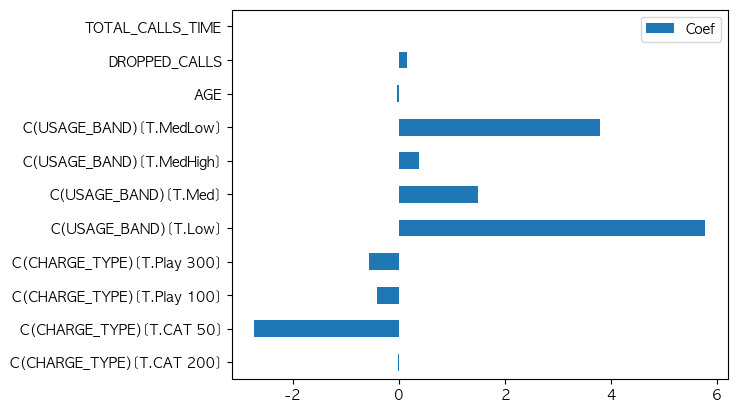

In [24]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")
# df_logistic_coef.plot.barh(y = "Coef", figsize=(10,6))

In [25]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_char = raw_data.select_dtypes(include = "object")
df_numeric = raw_data.select_dtypes(exclude = "object")

# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_scaled = pd.concat([df_numeric_scaled, df_char],axis = 1)
df_scaled.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,GENDER,CHARGE_TYPE,HANDSET,USAGE_BAND
0,-0.489898,-0.030604,-0.069958,0.949112,0.079015,-0.783880,F,CAT 100,ASAD170,Med
1,-0.489898,-0.335827,-0.243451,2.091732,0.259163,-0.458260,M,CAT 100,S50,Med
2,-0.489898,-0.335827,1.063386,2.377387,-0.325316,-0.817357,M,CAT 100,ASAD170,Med
3,-0.489898,2.258568,1.006966,-0.479163,-0.081116,-0.396795,M,CAT 100,ASAD170,Med
4,-0.489898,1.571816,1.530970,-0.764818,-0.289287,-0.709610,F,CAT 100,S50,Med


In [26]:
df_scaled["CHURN"] = np.where(df_scaled["CHURN"]> 0, 1, 0)
df_scaled.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,GENDER,CHARGE_TYPE,HANDSET,USAGE_BAND
0,0,-0.030604,-0.069958,0.949112,0.079015,-0.783880,F,CAT 100,ASAD170,Med
1,0,-0.335827,-0.243451,2.091732,0.259163,-0.458260,M,CAT 100,S50,Med
2,0,-0.335827,1.063386,2.377387,-0.325316,-0.817357,M,CAT 100,ASAD170,Med
3,0,2.258568,1.006966,-0.479163,-0.081116,-0.396795,M,CAT 100,ASAD170,Med
4,0,1.571816,1.530970,-0.764818,-0.289287,-0.709610,F,CAT 100,S50,Med


In [27]:
# 데이터 분할
df_scaled_train, df_scaled_test = train_test_split(df_scaled, # 데이터
                               test_size = 0.3, # test 데이터의 비율
                               random_state = 777)  # random state

In [28]:
# 선정된 설명변수 기준
scaled_log_model = Logit.from_formula(formula_text, df_scaled_train)
# 적합
scaled_log_result = scaled_log_model.fit()
# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.429191
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      639
Method:                           MLE   Df Model:                           11
Date:                Thu, 20 Mar 2025   Pseudo R-squ.:                  0.1185
Time:                        15:20:52   Log-Likelihood:                -279.40
converged:                       True   LL-Null:                       -316.98
Covariance Type:            nonrobust   LLR p-value:                 1.267e-11
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.8003      0.828     -3.382      0.001      

<Axes: >

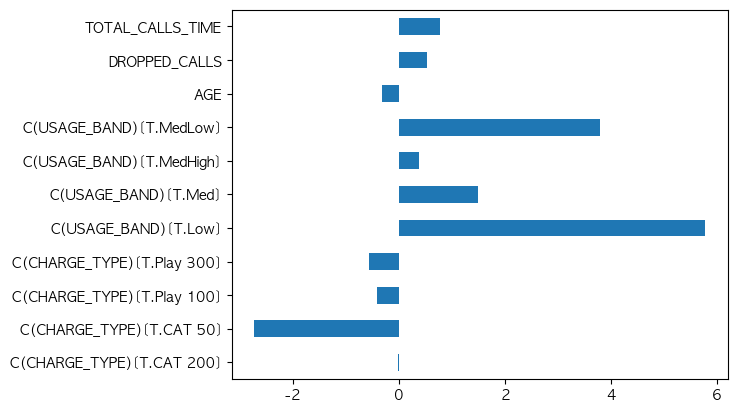

In [29]:
# 설명변수 중요도
df_log_scaled_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = "Coef", legend = False)